In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/amongnikol/belajar/refs/heads/main/dataset/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df[df.duplicated()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [5]:
df.drop(columns='id', inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

c:\Users\akmal\anaconda3\envs\jcopml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='count'>

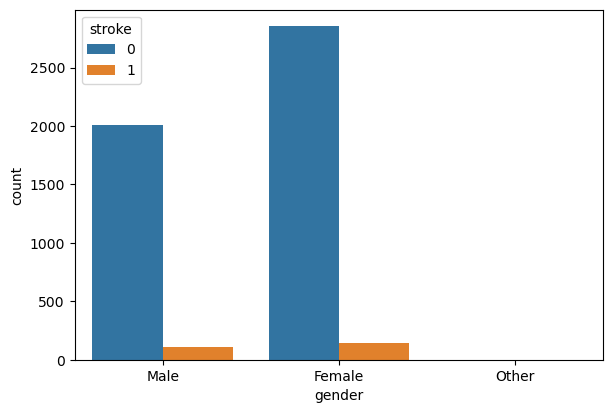

In [7]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
sns.countplot('gender', data=df, hue='stroke')


In [8]:
df.drop(df[df['gender'] == 'Other'].index, inplace=True)
df['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.0+ KB


In [10]:
from jcopml.plot import plot_correlation_matrix

plot_correlation_matrix(df, 'stroke', numeric_col = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'])

interactive(children=(ToggleButtons(description='method', options=('spearman', 'kendall', 'pearson', 'pearson_…

c:\Users\akmal\anaconda3\envs\jcopml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='hypertension', ylabel='count'>

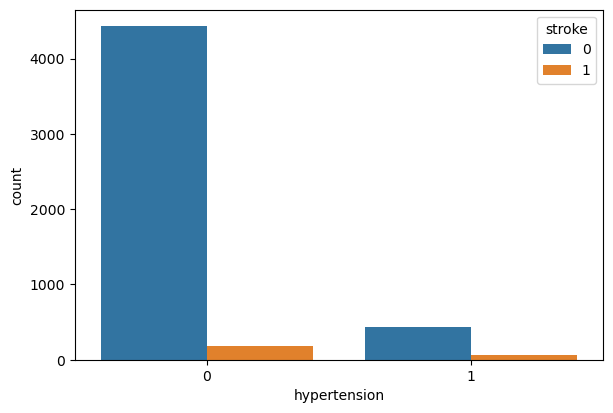

In [11]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
sns.countplot('hypertension', data=df, hue='stroke')


In [12]:
x = df.drop(columns='stroke')
y = df.stroke

# stratify untuk membagi target ke test dan training seimbang# training
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4087, 10), (1022, 10), (4087,), (1022,))

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import grid_search_params as gsp
from jcopml.tuning import random_search_params as rsp

In [14]:
x_train.head()


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
845,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked
3745,Female,29.0,0,0,No,Private,Urban,84.19,21.2,never smoked
4184,Female,35.0,0,0,Yes,Private,Rural,119.40,22.9,never smoked
3410,Male,38.0,0,0,Yes,Private,Rural,108.68,32.7,never smoked
284,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown


In [15]:
df.heart_disease.value_counts()

0    4833
1     276
Name: heart_disease, dtype: int64

In [16]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['avg_glucose_level', 'age', 'bmi']),
    ('categoric', cat_pipe(encoder='onehot'), ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

# cv = cross validation
model = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(x_train, y_train)

print(model.best_params_)
print(model.score(x_train, y_train), model.best_score_, model.score(x_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 20, 'algo__max_features': 0.3, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 100}
0.951309028627355 0.9513091425043875 0.9510763209393346


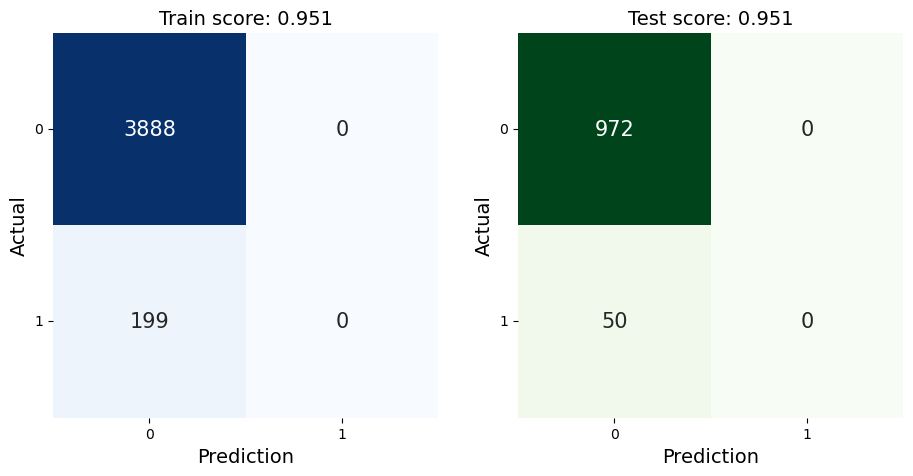

In [17]:
from jcopml.plot import plot_confusion_matrix

plot_confusion_matrix(x_train,y_train,x_test,y_test, model)

In [33]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['avg_glucose_level', 'age', 'bmi']),
    ('categoric', cat_pipe(encoder='onehot'), ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

# cv = cross validation
model = GridSearchCV(pipeline, gsp.rf_params, scoring='f1', cv=2, n_jobs=-1, verbose=1)
model.fit(x_train, y_train)

print(model.best_params_)
print(model.score(x_train, y_train), model.best_score_, model.score(x_test, y_test))

Fitting 2 folds for each of 81 candidates, totalling 162 fits
{'algo__max_depth': 20, 'algo__max_features': 0.3, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 150}
1.0 0.038461538461538464 0.07407407407407407


In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score

class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, threshold=0.5):
        self.base_estimator = base_estimator
        self.threshold = threshold
    
    def fit(self, X, y):
        self.base_estimator.fit(X, y)
        return self
    
    def predict(self, X):
        # Menggunakan threshold untuk menentukan prediksi kelas
        probas = self.base_estimator.predict_proba(X)[:, 1]  # Probabilitas kelas positif
        return (probas >= self.threshold).astype(int)
    
    def predict_proba(self, X):
        return self.base_estimator.predict_proba(X)

# Menyusun kembali pipeline menggunakan ThresholdClassifier
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42, threshold=0.3))  # Sesuaikan threshold
])

# Melakukan GridSearchCV pada pipeline
model = GridSearchCV(pipeline, gsp.rf_params, scoring='f1', cv=2, n_jobs=-1, verbose=1)
model.fit(x_train, y_train)

print(model.best_params_)
print("Train Score:", model.score(x_train, y_train))
print("Best Cross-Validation Score:", model.best_score_)
print("Test Score:", model.score(x_test, y_test))


TypeError: __init__() got an unexpected keyword argument 'threshold'

In [19]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve, plot_pr_curve

plot_classification_report(x_train, y_train, x_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3888
           1       1.00      1.00      1.00       199

    accuracy                           1.00      4087
   macro avg       1.00      1.00      1.00      4087
weighted avg       1.00      1.00      1.00      4087


Test report
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.50      0.04      0.07        50

    accuracy                           0.95      1022
   macro avg       0.73      0.52      0.52      1022
weighted avg       0.93      0.95      0.93      1022



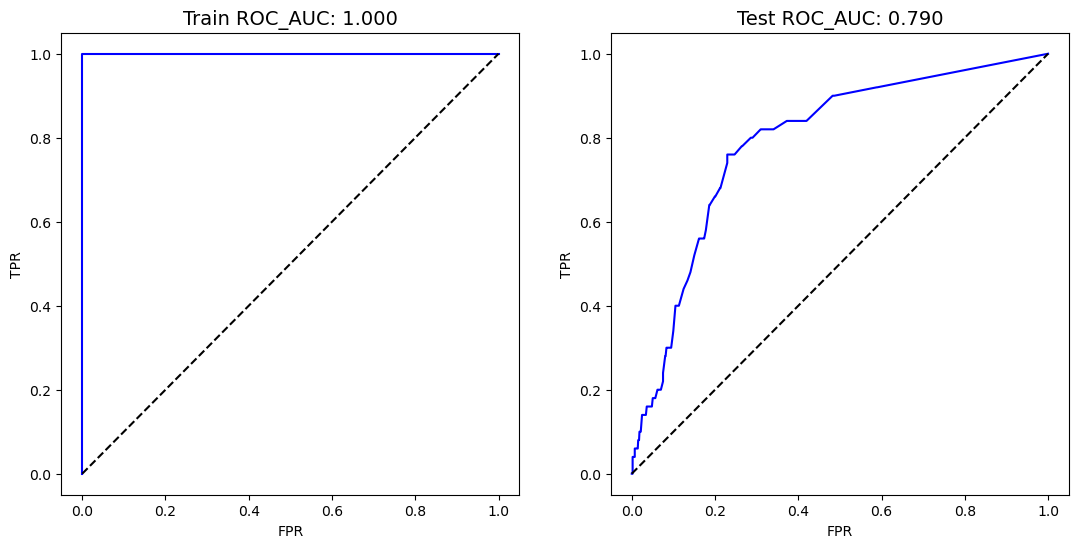

In [34]:
plot_roc_curve(x_train, y_train, x_test, y_test, model)

In [ ]:
plot_pr_curve(x_train, y_train, x_test, y_test, model)

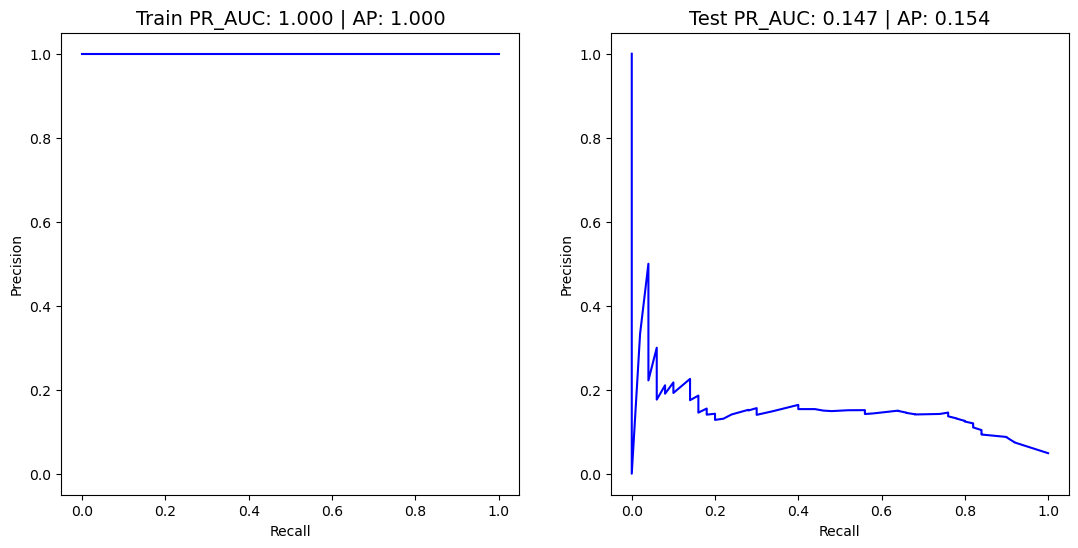

In [21]:
plot_pr_curve(x_train, y_train, x_test, y_test, model)

In [22]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['avg_glucose_level', 'age', 'bmi']),
    ('categoric', cat_pipe(encoder='onehot'), ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

# cv = cross validation
model = GridSearchCV(pipeline, gsp.rf_params, scoring='precision', cv=2, n_jobs=-1, verbose=1)
model.fit(x_train, y_train)

print(model.best_params_)
print(model.score(x_train, y_train), model.best_score_, model.score(x_test, y_test))

Fitting 2 folds for each of 81 candidates, totalling 162 fits
{'algo__max_depth': 20, 'algo__max_features': 0.6, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 100}
1.0 0.5 0.0


In [32]:
from sklearn.svm import SVC

# year disini masuk kedalam numerik agar model dapat membaca ketika terdapat tahun baru
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', transform='yeo-johnson'), ['avg_glucose_level', 'bmi']),
    ('categoric', cat_pipe(encoder='onehot'), ['gender', 'hypertension', 'heart_disease', 'Residence_type', 'smoking_status'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

parameter = {
    'algo__gamma': np.logspace(-3, 3, 7),
    'algo__C': np.logspace(-3, 3, 7),
    'algo__class_weight': [{0: x, 1: 1-x} for x in [0.01, 0.05, 0.1, 0.25]]
 }

# cv = cross validation
model = GridSearchCV(pipeline, parameter, cv=3, scoring='f1', n_jobs=-1, verbose=1)
model.fit(x_train, y_train)

print(model.best_params_)
print(model.score(x_train, y_train), model.best_score_, model.score(x_test, y_test))

c:\Users\akmal\anaconda3\envs\jcopml\lib\site-packages\jcopml\pipeline\_pipeline.py:66: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 196 candidates, totalling 588 fits


c:\Users\akmal\anaconda3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


{'algo__C': 10.0, 'algo__class_weight': {0: 0.1, 1: 0.9}, 'algo__gamma': 1.0}
0.13479853479853482 0.11767323383705923 0.11386861313868613


In [30]:
from xgboost import XGBClassifier
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['avg_glucose_level', 'age', 'bmi']),
    ('categoric', cat_pipe(encoder='onehot'), ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

# cv = cross validation
model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, scoring='f1', n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(x_train, y_train)

print(model.best_params_)
print(model.score(x_train, y_train), model.best_score_, model.score(x_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'algo__colsample_bytree': 0.5054493267725888, 'algo__gamma': 2, 'algo__learning_rate': 0.7902619549708234, 'algo__max_depth': 2, 'algo__n_estimators': 108, 'algo__reg_alpha': 0.0011584172310543986, 'algo__reg_lambda': 0.008386394780402564, 'algo__subsample': 0.42051273301300585}
0.38888888888888895 0.13057015448319798 0.13636363636363635


c:\Users\akmal\anaconda3\envs\jcopml\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [31]:
rsp.xgb_params

{'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

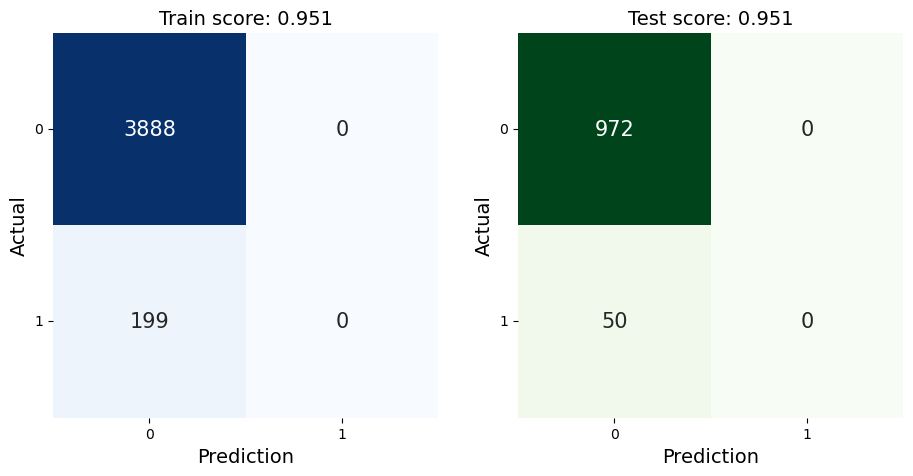

In [26]:
plot_confusion_matrix(x_train,y_train,x_test,y_test, model)

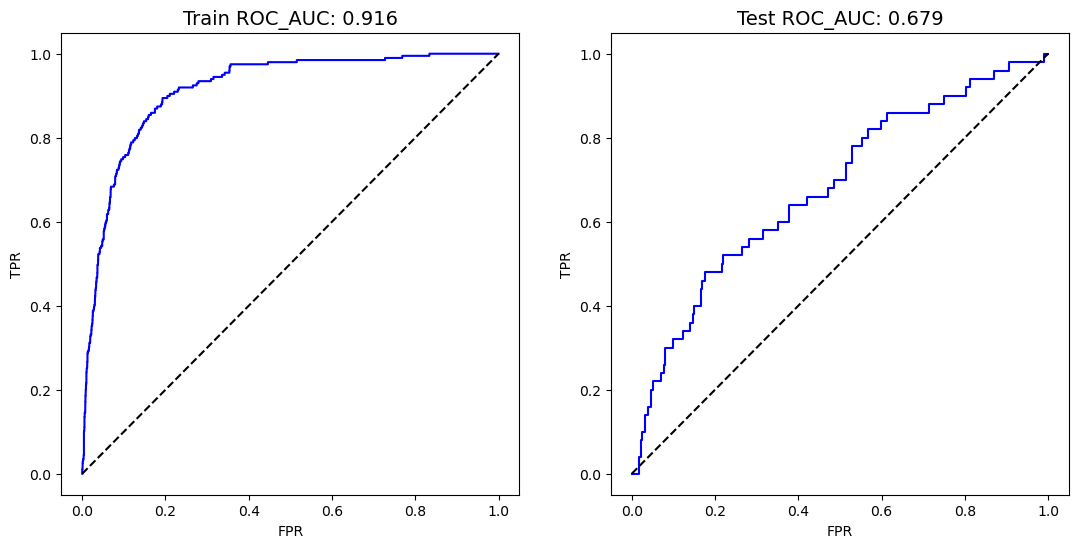

In [28]:
plot_roc_curve(x_train, y_train, x_test, y_test, model)